In [1]:
import os
os.chdir('../')
import logging
import numpy as np
logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
%load_ext autoreload
%autoreload 2

In [5]:
import scanpy as sc
metaset = sc.read('/home/xlv0877/proj_home/ExPert/results/e48fbfce53513a9f/perturb_metaset.h5ad', backed='r')

In [6]:
# clean up cell type column
# 1. change k562 to lymphoblast
metaset.obs.loc[metaset.obs.celltype=='K562','celltype'] = 'lymphoblasts'
# 2. unify iPSCs
metaset.obs.celltype = metaset.obs.celltype.str.split('-').str[0]
# check updated cell types
metaset.obs.celltype.value_counts()

celltype
lymphoblasts                        2326650
iPSC                                 491973
retinal pigment epithelial cells     234420
melanocytes                          211996
T cells                               86779
Name: count, dtype: int64

In [8]:
import pandas as pd
# add proper perturbation type label
dataset_meta = pd.read_csv('/projects/b1042/GoyalLab/lschwartz/ExPert/resources/datasets/meta/filtered_datasets.csv')
dataset_meta['dataset'] = (dataset_meta['publication index'] + '_' + dataset_meta['dataset index'].astype('string').fillna('')).str.rstrip('_')
dataset_meta = dataset_meta[['dataset', 'perturbation']]
dataset_meta.columns = ['dataset', 'perturbation_type']
metaset.obs.drop(columns=['perturbation_type'], inplace=True)
metaset.obs = metaset.obs.reset_index().merge(dataset_meta, on='dataset', how='left').set_index('index')
# create a cell-, and perturbation-specific gene perturbation
metaset.obs['exact_perturbation'] = metaset.obs['perturbation'].str.cat(metaset.obs['celltype'], sep=';').str.cat(metaset.obs['perturbation_type'], sep=';')

In [90]:
# remove multiple perturbations
all_perturbations = metaset.obs.perturbation.str.split('_', expand=True)
obs = metaset.obs
mask = all_perturbations.iloc[:,1].isna() | all_perturbations.iloc[:,1].str.isdigit()
obs = obs[mask].copy()
print(f'{metaset.obs.shape[0]-obs.shape[0]} multiple perturbations detected and removed')

268126 multiple perturbations detected and removed


In [91]:
obs['cleaned_pert'] = obs['perturbation'].astype(str)

In [92]:
# re-name perturbations from ShifrutMarson2018
special_perts = obs[obs['cleaned_pert'].str.startswith('ES.sg')]['perturbation']
obs.loc[obs['cleaned_pert'].str.startswith('ES.sg'), 'cleaned_pert'] = special_perts.str.split('.').str[-1]

In [93]:
obs['perturbation'] = obs['cleaned_pert']
obs.drop(columns=['cleaned_pert'], inplace=True)

In [165]:
# add pathway data to perturbations
import pandas as pd
if 'pathway' not in obs.columns:
    logging.info('Adding pathway clusters to obs')
    pw_map = pd.read_csv('/home/xlv0877/proj_home/dl/resources/gene_to_pw_group.csv', index_col=0)
    obs = obs.merge(pw_map, left_on='perturbation', right_on='gene', how='left')
    obs.pathway = obs.pathway.astype(str)
    obs.loc[obs.pathway=='nan', 'pathway'] = obs.loc[obs.pathway=='nan', 'perturbation'] 

2025-03-03 10:46:15,787 - INFO - Adding pathway clusters to obs


In [265]:
20_000 * 20_000 * 

60000000000

In [262]:
metaset.n_obs * metaset.n_vars

52419081702

In [242]:
# mark transcription factors in perturbations
if 'is_tf' not in obs.columns:
    logging.info('Adding TF info to perturbations')
    tf_info = pd.read_csv('/home/xlv0877/proj_home/dl/resources/tfs/htfs.txt', header=None)
    tf_info.columns = ['gene_name']
    obs['is_tf'] = obs['perturbation'].isin(tf_info['gene_name'])

2025-03-04 10:17:57,864 - INFO - Adding TF info to perturbations


In [256]:
obs[obs.is_tf].groupby(['celltype', 'perturbation_type']).perturbation.nunique()

celltype                          perturbation_type    
T cells                           CRISPR-cas9, TCR stim       2
iPSC                              CRISPRa                    15
                                  CRISPRi                     7
lymphoblasts                      CRISPRa                    44
                                  CRISPRi                  1595
melanocytes                       CRISPR-cas9                18
retinal pigment epithelial cells  CRISPRi                   135
Name: perturbation, dtype: int64

In [99]:
# get perturbations per dataset and order by number (single perturbations only)
perts_per_ds = obs.groupby('dataset', observed=True)['perturbation'].apply(lambda x: set(x))
perts_per_ds_order = obs.groupby('dataset', observed=True)['perturbation'].nunique().sort_values(ascending=False)
perts_per_ds.index = pd.Categorical(perts_per_ds.index, categories=perts_per_ds_order.index, ordered=True)
perts_per_ds.sort_index(inplace=True)

In [125]:
obs.groupby('celltype')['dataset'].value_counts()

celltype                          dataset                            
T cells                           ShifrutMarson2018                        50078
                                  DatlingerBock2021                        36701
iPSC                              TianKampmann2019_iPSC                   135047
                                  TianKampmann2019_day7neuron              81452
                                  TianKampmann2021_CRISPRi                 29004
                                  TianKampmann2021_CRISPRa                 18430
lymphoblasts                      ReplogleWeissman2022_K562_gwps         1918354
                                  ReplogleWeissman2022_K562_essential     300494
                                  NormanWeissman2019_filtered              67716
melanocytes                       FrangiehIzar2021_RNA                    211996
retinal pigment epithelial cells  ReplogleWeissman2022_rpe1               234420
Name: count, dtype: int64

In [127]:
# check all shared perturbations
shared_perturbations = set.intersection(*perts_per_ds)
logging.info(f'Found {len(shared_perturbations)} shared perturbation(s) across all datasets')

2025-03-02 18:42:39,402 - INFO - Found 1 shared perturbation(s) across all datasets


In [212]:
cls_label = 'pathway'
#cls_label = 'perturbation'
groups = ['celltype', 'perturbation_type']

In [216]:
cells_per_label = []
for label in ['perturbation', 'pathway']:
    vc = obs.groupby(groups, observed=True)[label].value_counts().reset_index()
    vc['label'] = vc[groups].agg(';'.join, axis=1)
    vc['log_count'] = np.log(vc['count'])
    vc['cls_label'] = label
    cells_per_label.append(vc)
cells_per_label = pd.concat(cells_per_label, axis=0)

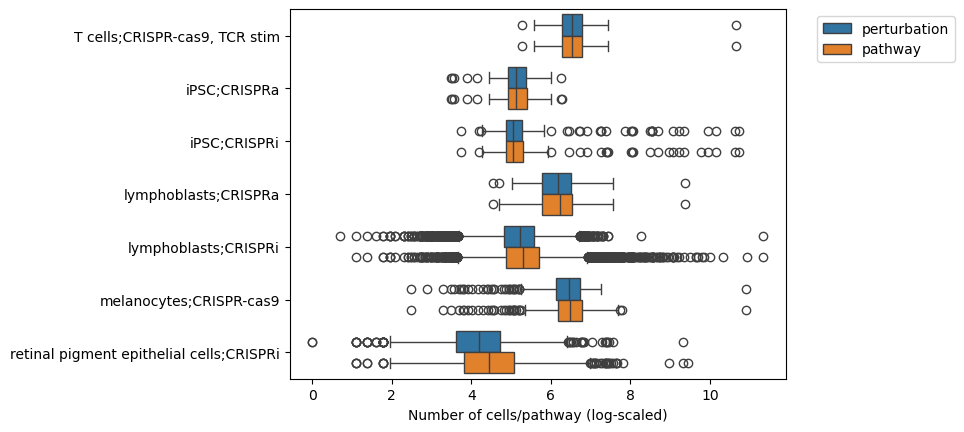

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(cells_per_label, x='log_count', y='label', hue='cls_label')
plt.ylabel('')
plt.xlabel(f'Number of cells/{cls_label} (log-scaled)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

In [227]:
cells_per_label.groupby('cls_label').nunique()

,celltype,perturbation_type,perturbation,count,label,log_count,pathway
cls_label,,,,,,,
pathway,5,4,0,1163,7,1163,6127
perturbation,5,4,10098,935,7,935,0


In [174]:
# Overall amount of perturbations per cell type and perturbation type
perts_per_groups = obs.groupby(groups, observed=True)['perturbation'].nunique()
perts_per_groups

celltype                          perturbation_type    
T cells                           CRISPR-cas9, TCR stim      61
iPSC                              CRISPRa                   101
                                  CRISPRi                   209
lymphoblasts                      CRISPRa                   106
                                  CRISPRi                  9871
melanocytes                       CRISPR-cas9               249
retinal pigment epithelial cells  CRISPRi                  2394
Name: perturbation, dtype: int64

In [177]:
# Overall amount of pathway perturbations per cell type and perturbation type
min_cells = 0
cls_per_groups = vc[vc['count'] >= min_cells].groupby(groups, observed=True)[cls_label].nunique()
cls_per_groups/perts_per_groups

celltype                          perturbation_type    
T cells                           CRISPR-cas9, TCR stim    1.000000
iPSC                              CRISPRa                  0.980198
                                  CRISPRi                  0.894737
lymphoblasts                      CRISPRa                  0.962264
                                  CRISPRi                  0.603282
melanocytes                       CRISPR-cas9              0.923695
retinal pigment epithelial cells  CRISPRi                  0.554302
dtype: float64

In [161]:
obs.groupby(['celltype', 'perturbation_type'], observed=True)['dataset'].value_counts()

celltype                          perturbation_type      dataset                            
T cells                           CRISPR-cas9, TCR stim  ShifrutMarson2018                        50078
                                                         DatlingerBock2021                        36701
iPSC                              CRISPRa                TianKampmann2021_CRISPRa                 18430
                                  CRISPRi                TianKampmann2019_iPSC                   135047
                                                         TianKampmann2019_day7neuron              81452
                                                         TianKampmann2021_CRISPRi                 29004
lymphoblasts                      CRISPRa                NormanWeissman2019_filtered              67716
                                  CRISPRi                ReplogleWeissman2022_K562_gwps         1918354
                                                         ReplogleWeissman20

In [179]:
min_cells = 200
vc[vc >= min_cells].reset_index().groupby(groups)[cls_label].value_counts()

celltype                          perturbation_type      pathway 
T cells                           CRISPR-cas9, TCR stim  BTLA        1
                                                         C10orf54    1
                                                         CBLB        1
                                                         CD5         1
                                                         DGKA        1
                                                                    ..
retinal pigment epithelial cells  CRISPRi                pw_730      1
                                                         pw_74       1
                                                         pw_746      1
                                                         pw_763      1
                                                         pw_771      1
Name: count, Length: 3640, dtype: int64

In [128]:
# filter for top 100 represented perturbations
N = 100
top_perturbations = obs['perturbation'].value_counts()[:N]

In [130]:
subset = metaset[metaset.obs.perturbation.isin(top_perturbations.index)]

In [131]:
subset.obs.groupby('dataset')['perturbation'].nunique()

dataset
DatlingerBock2021                       6
FrangiehIzar2021_RNA                   27
NormanWeissman2019_filtered            12
ReplogleWeissman2022_K562_essential    53
ReplogleWeissman2022_K562_gwps         89
ReplogleWeissman2022_rpe1              53
ShifrutMarson2018                       1
TianKampmann2019_day7neuron            21
TianKampmann2019_iPSC                  21
TianKampmann2021_CRISPRa                3
TianKampmann2021_CRISPRi                5
Name: perturbation, dtype: int64

In [132]:
subset.to_memory().write_h5ad('data/subset_top_100_all_datasets.h5ad')

... storing 'celltype' as categorical
... storing 'dataset' as categorical
... storing 'perturbation_type' as categorical
... storing 'exact_perturbation' as categorical
